In [1]:
# Tensorboard visualization for pytorch in Google Colab
!pip install tensorboardX
!pip install -q tf-nightly-2.0-preview
%load_ext tensorboard

     |████████████████████████████████| 133kB 41.8MB/s 
     |████████████████████████████████| 87.5MB 507kB/s 
     |████████████████████████████████| 430kB 50.4MB/s 
     |████████████████████████████████| 61kB 26.6MB/s 
     |████████████████████████████████| 3.1MB 49.1MB/s 
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.


In [0]:
# Heavily inspired by: https://github.com/pytorch/examples/blob/master/mnist/main.py
# And https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f
import os
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Cuda stuff
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device is " + str(device) + ".")

Device is cuda.


In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.hidden1 = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),       
        )
        
        self.hidden3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),     
        )
        
        self.out = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, img):
        x = self.hidden1(img)
        x = self.hidden2(x)
        x = self.hidden3(x)
        out= self.out(x)
        return out

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.hidden1 = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        
        self.hidden3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
        
    def forward(self, z):
        x = self.hidden1(z)
        x = self.hidden2(x)
        x = self.hidden3(x)
        out = self.out(x)
        return out

In [0]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss(reduction='mean')

In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    optimizer.zero_grad()
    
    # Real images
    predictions_real = discriminator(real_data)
    loss_real = loss(predictions_real, torch.ones_like(predictions_real))
    loss_real.backward()
    
    # Fake images
    predictions_fake = discriminator(fake_data)
    loss_fake = loss(predictions_fake, torch.zeros_like(predictions_fake))
    loss_fake.backward()
    
    optimizer.step()
    return (loss_real + loss_fake)/2.0

In [0]:
def train_generator(optimizer, fake_data):
    optimizer.zero_grad()
    
    predictions_fake = discriminator(fake_data)
    loss_fake = loss(predictions_fake, torch.ones_like(predictions_fake))
    loss_fake.backward()
    
    optimizer.step()
    return loss_fake

In [0]:
def images_to_vectors(images):
    return images.view(images.size(0), 28*28)
    
def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)
    
def noise(size):
    return Variable(torch.randn(size, 100)).to(device)

In [0]:
def load_mnist(batch_size):
    # Load data
    root = './data'
    if not os.path.exists(root):
        os.mkdir(root)

    # normalizes values to interval [-1, 1]
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
    test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

    train_loader = torch.utils.data.DataLoader(
                     dataset=train_set,
                     batch_size=batch_size,
                     shuffle=True)
    test_loader = torch.utils.data.DataLoader(
                    dataset=test_set,
                    batch_size=batch_size,
                    shuffle=False)
    return train_loader, test_loader

In [40]:
%tensorboard --logdir logs/1

In [41]:
num_epochs = 100
batch_size = 32

test_noise = noise(16)

train_loader, test_loader = load_mnist(batch_size)
!rm -rf logs/1
writer = SummaryWriter('logs/1')
iterations_gen = 0
for epoch in range(num_epochs):
    print("Epoch:", epoch)
    loss_d = 0
    loss_g = 0
    iterations = 0

    for n_batch, batch in enumerate(train_loader):
        fake_data = generator(noise(batch_size)).detach()
        real_data = Variable(images_to_vectors(batch[0])).to(device)
        loss_d += train_discriminator(d_optimizer, real_data, fake_data)
        
        fake_data = generator(noise(batch_size))
        loss_g += train_generator(g_optimizer, fake_data)

        if n_batch%100 == 0:
          test_gen = vectors_to_images(generator(test_noise))
          writer.add_image('test_gen', make_grid(test_gen), iterations_gen)
          iterations_gen += 1
          
        iterations += 1     
    writer.add_scalar('loss_d', loss_d/iterations, epoch)
    writer.add_scalar('loss_g', loss_g/iterations, epoch)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66


KeyboardInterrupt: ignored

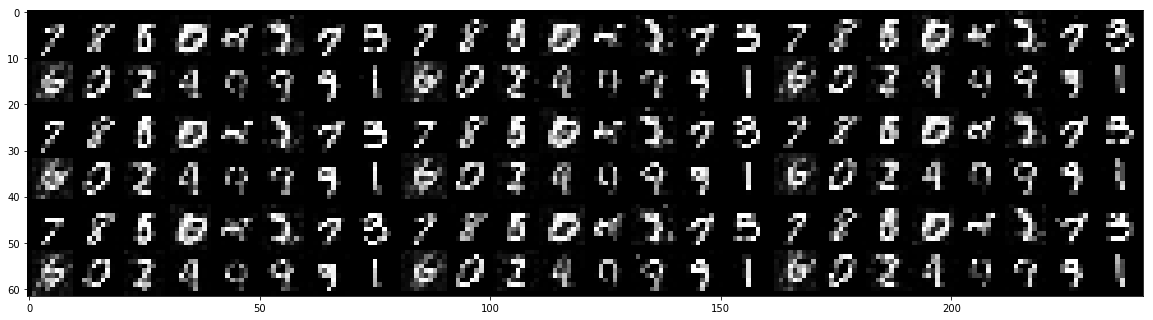

In [89]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

%matplotlib inline
test = vectors_to_images(generator(noise(16))).cpu()
test = make_grid(test, normalize = True)
test = test.data.numpy()
test = test.reshape(test.shape[1], test.shape[2], test.shape[0])
test = rgb2gray(test)

fig = plt.figure(figsize = (20,20))
plt.imshow(test, cmap=plt.cm.gray, interpolation='nearest')